# Combined Imports

In [210]:
import sys 
# Delete and then Utils Module to update content (needs to be optional)
if sys.modules.keys().__contains__('utils'):
    del sys.modules['utils']
if sys.modules.keys().__contains__('const'):
    del sys.modules['const']

import const
from utils import Utility
from utils import OptimizerModel

import maldi_learn.utilities as ml_utilities
import maldi_learn.driams as ml_driams
import maldi_learn.filters as ml_filters
import pandas as pd
import random
from collections import Counter
import time
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists
import optuna
import math
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn import tree
from sklearn import dummy
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

# different Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim_algo
import torch.utils.data as data


from optuna.samplers import RandomSampler
#import torch.optim.lr_scheduler as lr_scheduler

# Preprocessing

## Parameters

In [186]:
optim='aucroc'
bacterial_species = const.SPECIES_SAUREUS # Escherichia coli, Klebsiella pneumoniae, Staphylococcus aureus
bacterial_species_all = '*' # ALL species without filtering
predicted_antibiotics_loaded = [const.ANTIBIOTIC_OXACILLIN]#,const.ANTIBIOTIC_MEROPENEM,const.ANTIBIOTIC_CIPROFLOXACIN,const.ANTIBIOTIC_PIPTAZ] #[const.ANTIBIOTIC_CEFTRIAXONE,const.ANTIBIOTIC_OXACILLIN] # Ciprofloxacin etc.
predicted_antibiotic = const.ANTIBIOTIC_OXACILLIN
binning = const.BINNING_6K # Which Binning is to be used? TODO: Implement usage of both
if(binning==const.BINNING_6K):
    n_bins=6000
else:
    n_bins=18000
driams_dataset_label = const.DATASET_DRIAMSA # Which Dataset is to be used? TODO: Implement Functionality to use both

## Loading & Binning

In [ ]:
# DRIAMS B
X_train_multiple, y_train_multiple, X_test_multiple, y_test_multiple,driams_dataset = Utility.load_data(bacterial_species,predicted_antibiotics_loaded,'DRIAMS_B',['2018'],binning)

In [86]:
# DRIAMS A
X_train_multiple, y_train_multiple, X_test_multiple, y_test_multiple,driams_dataset = Utility.load_data(bacterial_species,predicted_antibiotics_loaded,'DRIAMS_A',['2015','2016','2017','2018'],binning)

In [87]:
X_train =   None
y_train =   None
X_test  =   None
y_test  =   None

X_train = X_train_multiple[predicted_antibiotic]
y_train = y_train_multiple[predicted_antibiotic]
X_test = X_test_multiple[predicted_antibiotic]
y_test = y_test_multiple[predicted_antibiotic]

## Scaling

In [88]:
# TODO: Implement Scaler
#scaler = StandardScaler()

## Initialization for ML

In [89]:
# Baseline Models
baseline_models = {}

# Tensors
X_train_tensor = {}
y_train_tensor = {}
train_dataset = {}

for dataset_label in const.US_NO, const.US_RANDOM:
    # Do Undersampling depending on dataset_label
    X, y = Utility.select_undersampling_dataset(X_train,y_train,dataset_label)
    baseline_models[dataset_label] = {}

    # MLP AND CNN use tensors, because they are implemented through pytorch
    # Initialize Tensors
    X_train_tensor[dataset_label] = torch.FloatTensor(X)
    y_train_tensor[dataset_label] = torch.LongTensor(y)
    train_dataset[dataset_label] = data.TensorDataset(X_train_tensor[dataset_label],y_train_tensor[dataset_label] )
    # Initialize Baseline OptimizerModels
    for method in const.METHOD_DUMMY,const.METHOD_LR, const.METHOD_RFO, const.METHOD_TREE:
        baseline_models[dataset_label][method] = OptimizerModel(dataset_label,method,X,y)

# Initialize target Tensors
X_test_tensor            = torch.FloatTensor(X_test)
y_test_tensor            = torch.LongTensor(y_test)
test_dataset             = data.TensorDataset(X_train_tensor[dataset_label],y_train_tensor[dataset_label])

# Classification/Hyperparameter Search

## Baseline Hyperparameter Optimization with CV

In [90]:
def train_hyperparams(a_predicted_antibiotic,a_bacterial_species,a_set_label,a_driams_dataset_label,a_binning,a_baseline_models,a_method):
    # File Identifier for saving and reloading Hyperparameters
    file_id = Utility.create_file_identifier(a_predicted_antibiotic,a_bacterial_species,a_method,a_set_label,a_binning,a_driams_dataset_label)
    # Current Model
    current_model = a_baseline_models[a_set_label][a_method]        
    # Calculate Best Params (5 Fold CV)
    best_params = Utility.optimize(current_model)
    # Set Best Params
    current_model.set_best_params(best_params)
    Utility.save_best_params(file_id,current_model.best_params)

In [91]:
# Dummy Classifier
for undersampling in baseline_models:
    train_hyperparams(predicted_antibiotic,bacterial_species,undersampling,driams_dataset_label,binning,baseline_models,const.METHOD_DUMMY)
    print(baseline_models[undersampling][const.METHOD_DUMMY].best_params)

{'strategy': 'uniform'}
{'strategy': 'uniform'}


In [92]:
# Tree Classifier
for undersampling in baseline_models:
    train_hyperparams(predicted_antibiotic,bacterial_species,undersampling,driams_dataset_label,binning,baseline_models,const.METHOD_TREE)
    print(baseline_models[undersampling][const.METHOD_TREE].best_params)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_features': None}
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_features': None}


In [93]:
# Logistic Regression Classifier
for undersampling in baseline_models:
    train_hyperparams(predicted_antibiotic,bacterial_species,undersampling,driams_dataset_label,binning,baseline_models,const.METHOD_LR)
    print(baseline_models[undersampling][const.METHOD_LR].best_params)

c:\Users\jonas\anaconda3\envs\master-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jonas\anaconda3\envs\master-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jonas\anaconda3\envs\master-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jonas\anaconda3\envs\master-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jonas\anaconda3\envs\master-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jonas\anaconda3\envs\

{'C': 1000.0, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


c:\Users\jonas\anaconda3\envs\master-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jonas\anaconda3\envs\master-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jonas\anaconda3\envs\master-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jonas\anaconda3\envs\master-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jonas\anaconda3\envs\master-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jonas\anaconda3\envs\

{'C': 1000.0, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


In [94]:
# Random Forest Classifier
for undersampling in baseline_models:
    train_hyperparams(predicted_antibiotic,bacterial_species,undersampling,driams_dataset_label,binning,baseline_models,const.METHOD_RFO)
    print(baseline_models[undersampling][const.METHOD_RFO].best_params)

{'class_weight': None, 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 1000}
{'class_weight': None, 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 1000}


## Baseline Classification

In [173]:
# Train Final model for all Classifiers
undersampling = const.US_RANDOM# const.US_RANDOM

for method in baseline_models[undersampling]:
    file_id = Utility.create_file_identifier(predicted_antibiotic,bacterial_species,method,undersampling,binning,driams_dataset_label)
    current_model = baseline_models[undersampling][method]      

    best_params = Utility.load_best_params(file_id)
    # Set loaded Params
    current_model.set_best_params(best_params)
    # Predict actual Test Data with Best Params
    y_test_pred,y_test_proba = Utility.predict_with_best(current_model,X_test)
    # Set Predicted Labels to later compare them
    current_model.set_predicted_labels(y_test_pred,y_test_proba)
    # Save Values for next usage.
    Utility.save_predictions(file_id,current_model.predicted_labels)
    Utility.save_probas(file_id,current_model.predicted_probas)

c:\Users\jonas\anaconda3\envs\master-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Models

### Final MLP Model

In [96]:
# Class Definition for MLP
class MLP_FINAL(nn.Module):
    def __init__(self,optuna_trial, n_bins,parameters):
        super().__init__()
        output_dim = const.OUTPUT_DIM  # One
        # Select or evaluate Hyperparameters #
        if optuna_trial is not None and parameters is None: # Parameters not provided, let optuna create params
            dropout = optuna_trial.suggest_float('dropout',0,0.5,step=0.5)
            no_of_hiddenlayers = optuna_trial.suggest_int('no_of_hidden',1,3)
            neuron_layer = {}
            max_neurons = 500
            for i in range(no_of_hiddenlayers):
                min_neurons = (no_of_hiddenlayers-i)+1
                neuron_layer[i] = optuna_trial.suggest_int('units_hiddenlayer'+str(i),min_neurons, max_neurons)
                max_neurons= neuron_layer[i]            
        if optuna_trial is None and parameters is not None: # Parameters are provided
            dropout = parameters['dropout']
            no_of_hiddenlayers = parameters['no_of_hidden']
            neuron_layer = {}
            for i in range(no_of_hiddenlayers):
                neuron_layer[i] = parameters['units_hiddenlayer'+str(i)]
        ########################################
        # Initialize Network Architecture #
        self.first_layer = nn.Linear(n_bins, neuron_layer[0])
        self.first_dropout = nn.Dropout(p=dropout)
        self.first_activation = nn.ReLU()

        middle_layers = []
        for i in range(1,no_of_hiddenlayers): # 1,2,3 for no_of_hiddenlayers = 4
            middle_layers.append(nn.Linear(neuron_layer[i-1], neuron_layer[i]))
            middle_layers.append(nn.Dropout(p=dropout))
            middle_layers.append(nn.ReLU())
            
        self.middle_layers = nn.Sequential(*middle_layers)    
        
        self.final_layer = nn.Linear(neuron_layer[no_of_hiddenlayers-1], output_dim) # Last Hidden Layer output
        self.final_dropout = nn.Dropout(p=dropout)
        self.final_activation = nn.Sigmoid()
        ########################################
    # One Forward Pass through the network #
    def forward(self, x):
        x = self.first_layer(x)
        x = self.first_dropout(x)
        x = self.first_activation(x)
        x = self.middle_layers(x)
        x = self.final_layer(x)
        x = self.final_dropout(x)
        x = self.final_activation(x)
        return x    

### Final CNN Model

In [97]:
### Class CNN Definition
class CNN_FINAL(nn.Module):
    def __init__(self,optuna_trial,n_bins,parameters):
        super().__init__()
        output_dim = const.OUTPUT_DIM
        ################################## Suggest Parameters #######################
        if optuna_trial is not None and parameters is None: # Parameters not provided, let optuna create params
            # Determine Params for Multilayer
            initial_pooling = optuna_trial.suggest_categorical('initial_pooling',[True,False])
            dropout_mlp = optuna_trial.suggest_float('dropout_mlp',0,0.5,step=0.5)
            dropout_cnn = optuna_trial.suggest_float('dropout_cnn',0,0.2,step=0.2)
            batchnorm = optuna_trial.suggest_categorical('initial_pooling',[True,False])
            subsampling_strategy = optuna_trial.suggest_categorical('subsampling_strategy',['stride','pooling','both'])
            if((subsampling_strategy=='pooling')|(subsampling_strategy=='both')):
                pooling_size = optuna_trial.suggest_int('pooling_size',3,7,2)
                pooling_stride = optuna_trial.suggest_categorical('pooling_stride',[2,None])
            else:
                pooling_size = 1
                pooling_stride = 1
            if((subsampling_strategy=='stride')|(subsampling_strategy=='both')):
                stride = optuna_trial.suggest_categorical('stride',[2,3,5])
            else:
                stride = 1 

            dense_neurons = optuna_trial.suggest_int('dense_neurons',1,500)        
            no_of_cnnlayers = optuna_trial.suggest_int('no_of_cnnlayers',1,4)
            filters = {}
            kernel_sizes = {}
            for i in range(no_of_cnnlayers):
                filters[i] = optuna_trial.suggest_int('filter'+str(i),1, 128)
                kernel_sizes[i] = optuna_trial.suggest_categorical('kernel_size'+str(i),[3,5,7,11,21,41])
        
        ################################## Use Parameters provided #######################
        if optuna_trial is None and parameters is not None: # Parameters are provided
            initial_pooling = parameters['initial_pooling']
            dropout_mlp = parameters['dropout_mlp']
            dropout_cnn = parameters['dropout_cnn']
            batchnorm = parameters['batchnorm']
            subsampling_strategy = parameters['subsampling_strategy']            
            if((subsampling_strategy=='pooling')|(subsampling_strategy=='both')):
                pooling_size = parameters['pooling_size']
                pooling_stride = parameters['pooling_stride']
            else:
                pooling_size = 1
                pooling_stride = 1
            if((subsampling_strategy=='stride')|(subsampling_strategy=='both')):
                stride = parameters['stride']
            else:
                stride = 1
            dense_neurons = parameters['dense_neurons'] 
            no_of_cnnlayers = parameters['no_of_cnnlayers']
            filters = {}
            kernel_sizes = {}
            for i in range(no_of_cnnlayers):
                filters[i] = parameters['filter'+str(i)]
                kernel_sizes[i] = parameters['kernel_size'+str(i)]

        ########################### CNN Architecture ############################

        activation=nn.ReLU()
        pooling = nn.AvgPool1d(pooling_size,stride=pooling_stride,padding=pooling_size//pooling_stride)
        dropout_cnn = nn.Dropout(p=dropout_cnn)
        self.dropout_mlp = nn.Dropout(p=dropout_mlp)
        
        # Layers for Sequential
        layers = []
        # Initial Pooling
        if(initial_pooling): 
            layers.append(nn.AvgPool1d(pooling_size,stride=pooling_stride,padding=pooling_size//pooling_stride))

        # First CNN Layer
        layers.append(nn.Conv1d(in_channels=1,out_channels=filters[0], kernel_size=kernel_sizes[0],stride=stride))
        if(batchnorm):
            layers.append(nn.BatchNorm1d(filters[0]))
        layers.append(dropout_cnn)
        layers.append(activation)
        layers.append(pooling)

        # Subsequent CNN Layers
        for i in range(1,no_of_cnnlayers): # 1,2,3 for no_of_hiddenlayers = 4
            layers.append(nn.Conv1d(in_channels=filters[i-no_of_cnnlayers],out_channels=filters[i], kernel_size=kernel_sizes[0],stride=stride))
            if(batchnorm):
                layers.append(nn.BatchNorm1d(filters[i]))
            layers.append(dropout_cnn)
            layers.append(activation)
            layers.append(pooling)            
        
        # Add CNN Layers to Sequential
        self.conv_layers = nn.Sequential(*layers)

        # Create Random Tensor, to find out MLP Input
        x = torch.randn(1,n_bins).view(-1,1,n_bins)
        self._to_linear = None
        self.convs(x)

        # MLP Layer
        self.mlp = nn.Linear(self._to_linear, dense_neurons)
        # Output Layer
        self.classifier = nn.Sequential(
            nn.Linear(dense_neurons, output_dim),
			nn.Sigmoid(),
		)
    # Apply Convolutions
    def convs(self,x):
        x=self.conv_layers(x)
       
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]
        return x
    # Forward Iteration through CNN
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # Flatten by Applying View
        x = F.relu(self.mlp(x))
        x = self.dropout_mlp(x)
        x = self.classifier(x)
        return x

# Basic Methods for Training

In [211]:
import logging
from optuna.samplers import RandomSampler
#import torch.optim.lr_scheduler as lr_scheduler

def do_study(file_id,n_trials,load_study_flag,X_train,y_train,method,n_bins,model_class):
    if(load_study_flag==False): # Create New study and do n_trials on it
        try:
            optuna.delete_study(study_name = file_id,storage='sqlite:///example.db')
        except:
            print('shit')
        finally:
            study= optuna.create_study(direction='maximize',study_name = file_id,storage='sqlite:///example.db')
        study.optimize(lambda trial: optimize_py(trial,method, X_train,y_train,n_bins,model_class), n_trials=n_trials)
        return study
    elif(load_study_flag==True): # Load study and do as many trials so atleast n_trials total are done 
        try:
            study= optuna.load_study(study_name = file_id, storage='sqlite:///example.db')
        except:
            study= optuna.create_study(direction='maximize',study_name = file_id,storage='sqlite:///example.db')
        if(n_trials-len(study.trials)>0):
            study.optimize(lambda trial: optimize_py(trial,method, X_train,y_train,n_bins,model_class), n_trials=n_trials-len(study.trials))
        return study
    
def optimize_py(trial,method,X_train,y_train,n_bins,model_class):        
    scores=[]
    # Split Train Data
    train_data, valid_data = Utility.split_dataset(X_train,y_train,True,trial.suggest_categorical(const.BATCH_SIZE,[4,8,16,32,64]))
    for fold in train_data:
        model,optimizer,criterion,device = initialize_model(n_bins,method,model_class,trial=trial)    
        suggested_epochs=trial.suggest_int(const.EPOCHS,20,100)
        weighted_flag=trial.suggest_categorical(const.WEIGHTED_FLAG,[True,False])
        final_score, pred, proba, aucroc_scores,preds,probas,training_scores =  Utility.training_epochs(suggested_epochs,train_data[fold],valid_data[fold],model,optimizer,criterion,device,weighted_flag)
        scores.append(final_score)
    print(final_score)
    return np.mean(scores)
def initialize_model(n_bins,method,model_class,trial=None,best_params=None):
    model = model_class(trial,n_bins,best_params)          
    if trial is None:
        learning_rate = best_params[const.LEARNING_RATE]
    else:
        # use logarithmic distribution for learning rate
        learning_rate = trial.suggest_float(const.LEARNING_RATE, 1e-7, 1e-3, log=True)
    
    optimizer = optim_algo.Adam(model.parameters(),lr=learning_rate) # No scheduler currently

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #
    if(const.OUTPUT_DIM==1):
        criterion = nn.BCELoss()
    else:
        raise ValueError(const.OUTPUT_DIM)
    model = model.to(device)
    criterion = criterion.to(device)
    return model,optimizer,criterion,device
def predict_with_best_py(best_params,train_iterator,test_iterator,n_bins,method,model_class):

        # Initialize Model with given Method and Parameters
        model,optimizer,criterion,device = initialize_model(n_bins,method,model_class,best_params=best_params)   
        model_parameters = filter(lambda p: p.requires_grad, model.parameters())
        print(sum([np.prod(p.size()) for p in model_parameters])) 

        # Calculate Shapley values
        #explainer = shap.DeepExplainer(model,train_iterator)

        # Train over given number of Epochs, with best Parameters
        weighted_flag = best_params[const.WEIGHTED_FLAG]
        aucroc, pred, proba, scores,preds,probas,training_scores = Utility.training_epochs(best_params[const.EPOCHS],train_iterator,test_iterator,model,optimizer,criterion,device,weighted_flag)

        #shap_values = explainer(train_iterator)

        # Return Predictions and Probabilities
        return pred, proba, scores,preds,probas,training_scores
        #return shap_values

In [208]:
print(len(y_train))
print(len(y_test))

2742
669


## Optimize MLP

In [212]:
loadmlp = False # Variable for only loading or calculating new trials
n_trials_mlp = 50 # Optuna Trials

for dataset_label in const.US_NO,const.US_RANDOM:
    name = Utility.create_file_identifier(predicted_antibiotic,bacterial_species,const.METHOD_MLP,dataset_label,binning,driams_dataset_label)
    study_mlp= do_study(name,n_trials_mlp,loadmlp,X_train_tensor[dataset_label],y_train_tensor[dataset_label],const.METHOD_MLP,n_bins,MLP_FINAL) # create/load/do study, return best Params
    Utility.save_best_params(name+'_'+str(len(study_mlp.trials))+'_trials',study_mlp.best_params)

shit


[I 2023-05-30 14:51:00,087] A new study created in RDB with name: Oxacillin_Staphylococcus aureus_not_undersampled_6k_DRIAMS_A_mlp_aucroc_eval
[I 2023-05-30 14:51:52,187] Trial 0 finished with value: 0.8966031943781412 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 162, 'units_hiddenlayer1': 18, 'units_hiddenlayer2': 12, 'learning_rate': 0.0007286669492592939, 'epochs': 46, 'weighted_flag': True}. Best is trial 0 with value: 0.8966031943781412.


0.9044715447154471
0.8154398954703833


[I 2023-05-30 14:54:40,814] Trial 1 finished with value: 0.7996814566104751 and parameters: {'batch_size': 4, 'dropout': 0.5, 'no_of_hidden': 1, 'units_hiddenlayer0': 414, 'learning_rate': 0.00027649438536177847, 'epochs': 32, 'weighted_flag': False}. Best is trial 0 with value: 0.8966031943781412.


0.5438443670150986


[I 2023-05-30 14:55:29,833] Trial 2 finished with value: 0.5333306605003039 and parameters: {'batch_size': 64, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 133, 'units_hiddenlayer1': 29, 'units_hiddenlayer2': 7, 'learning_rate': 1.5487163936570152e-06, 'epochs': 83, 'weighted_flag': False}. Best is trial 0 with value: 0.8966031943781412.
[I 2023-05-30 14:56:58,899] Trial 3 finished with value: 0.5333646871853719 and parameters: {'batch_size': 16, 'dropout': 0.0, 'no_of_hidden': 2, 'units_hiddenlayer0': 170, 'units_hiddenlayer1': 107, 'learning_rate': 2.6157670433910984e-06, 'epochs': 64, 'weighted_flag': False}. Best is trial 0 with value: 0.8966031943781412.


0.538109756097561
0.7159552845528455


[I 2023-05-30 14:57:25,756] Trial 4 finished with value: 0.6811726037612843 and parameters: {'batch_size': 64, 'dropout': 0.5, 'no_of_hidden': 1, 'units_hiddenlayer0': 312, 'learning_rate': 0.0001446475645324362, 'epochs': 49, 'weighted_flag': False}. Best is trial 0 with value: 0.8966031943781412.
[I 2023-05-30 14:58:30,917] Trial 5 finished with value: 0.5340631135281546 and parameters: {'batch_size': 64, 'dropout': 0.5, 'no_of_hidden': 3, 'units_hiddenlayer0': 236, 'units_hiddenlayer1': 36, 'units_hiddenlayer2': 14, 'learning_rate': 5.247789190657983e-06, 'epochs': 98, 'weighted_flag': False}. Best is trial 0 with value: 0.8966031943781412.


0.5400878339140534
0.7201655052264808


[I 2023-05-30 15:01:14,798] Trial 6 finished with value: 0.7181622072332259 and parameters: {'batch_size': 8, 'dropout': 0.5, 'no_of_hidden': 1, 'units_hiddenlayer0': 469, 'learning_rate': 4.6270150591501606e-05, 'epochs': 57, 'weighted_flag': False}. Best is trial 0 with value: 0.8966031943781412.


0.6828179442508711


[I 2023-05-30 15:01:40,825] Trial 7 finished with value: 0.6297116882153121 and parameters: {'batch_size': 64, 'dropout': 0.5, 'no_of_hidden': 2, 'units_hiddenlayer0': 327, 'units_hiddenlayer1': 8, 'learning_rate': 0.00012560487779996162, 'epochs': 46, 'weighted_flag': False}. Best is trial 0 with value: 0.8966031943781412.


0.5422473867595818


[I 2023-05-30 15:03:19,190] Trial 8 finished with value: 0.5382143017769843 and parameters: {'batch_size': 16, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 287, 'units_hiddenlayer1': 248, 'units_hiddenlayer2': 184, 'learning_rate': 2.0450868911136753e-06, 'epochs': 63, 'weighted_flag': False}. Best is trial 0 with value: 0.8966031943781412.
[I 2023-05-30 15:04:05,944] Trial 9 finished with value: 0.5436106374845986 and parameters: {'batch_size': 16, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 270, 'units_hiddenlayer1': 127, 'units_hiddenlayer2': 106, 'learning_rate': 1.0328774279328906e-07, 'epochs': 31, 'weighted_flag': False}. Best is trial 0 with value: 0.8966031943781412.


0.6109356852497096


[I 2023-05-30 15:04:27,242] Trial 10 finished with value: 0.6984755721426119 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 2, 'units_hiddenlayer0': 7, 'units_hiddenlayer1': 3, 'learning_rate': 0.0004294389673387849, 'epochs': 21, 'weighted_flag': True}. Best is trial 0 with value: 0.8966031943781412.


0.7508892276422764
0.8790287456445993


[I 2023-05-30 15:08:13,327] Trial 11 finished with value: 0.8621261832586846 and parameters: {'batch_size': 4, 'dropout': 0.5, 'no_of_hidden': 1, 'units_hiddenlayer0': 465, 'learning_rate': 0.0007180527466562057, 'epochs': 37, 'weighted_flag': True}. Best is trial 0 with value: 0.8966031943781412.


0.8935648954703832


[I 2023-05-30 15:11:20,131] Trial 12 finished with value: 0.8687715918808842 and parameters: {'batch_size': 4, 'dropout': 0.0, 'no_of_hidden': 1, 'units_hiddenlayer0': 62, 'learning_rate': 0.00098608100234467, 'epochs': 40, 'weighted_flag': True}. Best is trial 0 with value: 0.8966031943781412.


0.8967407084785134


[I 2023-05-30 15:12:05,391] Trial 13 finished with value: 0.8842209058483856 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 2, 'units_hiddenlayer0': 35, 'units_hiddenlayer1': 16, 'learning_rate': 0.0009256626834561562, 'epochs': 46, 'weighted_flag': True}. Best is trial 0 with value: 0.8966031943781412.


0.7467334494773519


[I 2023-05-30 15:12:59,184] Trial 14 finished with value: 0.7713781168863294 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 2, 'units_hiddenlayer0': 108, 'units_hiddenlayer1': 32, 'learning_rate': 4.957444569747554e-05, 'epochs': 54, 'weighted_flag': True}. Best is trial 0 with value: 0.8966031943781412.


0.5


[I 2023-05-30 15:14:20,555] Trial 15 finished with value: 0.6033267037222412 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 2, 'units_hiddenlayer0': 4, 'units_hiddenlayer1': 2, 'learning_rate': 0.0006898941013895581, 'epochs': 80, 'weighted_flag': True}. Best is trial 0 with value: 0.8966031943781412.


0.9010598141695702


[I 2023-05-30 15:15:39,053] Trial 16 finished with value: 0.8966471199688684 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 196, 'units_hiddenlayer1': 59, 'units_hiddenlayer2': 26, 'learning_rate': 0.00019759820473574835, 'epochs': 71, 'weighted_flag': True}. Best is trial 16 with value: 0.8966471199688684.


0.8220455865272938


[I 2023-05-30 15:17:02,739] Trial 17 finished with value: 0.8168011775778435 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 201, 'units_hiddenlayer1': 65, 'units_hiddenlayer2': 28, 'learning_rate': 4.39771929903498e-05, 'epochs': 75, 'weighted_flag': True}. Best is trial 16 with value: 0.8966471199688684.
[I 2023-05-30 15:21:16,043] Trial 18 finished with value: 0.8929186562995868 and parameters: {'batch_size': 8, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 362, 'units_hiddenlayer1': 193, 'units_hiddenlayer2': 68, 'learning_rate': 0.00020887385392703297, 'epochs': 72, 'weighted_flag': True}. Best is trial 16 with value: 0.8966471199688684.


0.9000072590011614
0.774027293844367


[I 2023-05-30 15:23:05,366] Trial 19 finished with value: 0.7729481578547773 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 195, 'units_hiddenlayer1': 69, 'units_hiddenlayer2': 27, 'learning_rate': 1.887907501566375e-05, 'epochs': 98, 'weighted_flag': True}. Best is trial 16 with value: 0.8966471199688684.
[I 2023-05-30 15:24:45,842] Trial 20 finished with value: 0.8966321813915566 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 107, 'units_hiddenlayer1': 47, 'units_hiddenlayer2': 18, 'learning_rate': 0.0003271624096128993, 'epochs': 88, 'weighted_flag': True}. Best is trial 16 with value: 0.8966471199688684.


0.9025479094076654


[I 2023-05-30 15:26:26,170] Trial 21 finished with value: 0.8994912129543307 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 102, 'units_hiddenlayer1': 46, 'units_hiddenlayer2': 17, 'learning_rate': 0.00030504536596066216, 'epochs': 89, 'weighted_flag': True}. Best is trial 21 with value: 0.8994912129543307.


0.9088269454123112
0.9018583042973287


[I 2023-05-30 15:28:05,080] Trial 22 finished with value: 0.8942561739123358 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 85, 'units_hiddenlayer1': 50, 'units_hiddenlayer2': 21, 'learning_rate': 0.0002747309379364895, 'epochs': 89, 'weighted_flag': True}. Best is trial 21 with value: 0.8994912129543307.


0.881315331010453


[I 2023-05-30 15:29:45,636] Trial 23 finished with value: 0.861088413268817 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 130, 'units_hiddenlayer1': 58, 'units_hiddenlayer2': 20, 'learning_rate': 8.040295674315628e-05, 'epochs': 89, 'weighted_flag': True}. Best is trial 21 with value: 0.8994912129543307.
[I 2023-05-30 15:31:02,469] Trial 24 finished with value: 0.8937286636498778 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 228, 'units_hiddenlayer1': 86, 'units_hiddenlayer2': 41, 'learning_rate': 0.0002624782797551017, 'epochs': 69, 'weighted_flag': True}. Best is trial 21 with value: 0.8994912129543307.


0.9038182346109176
0.8817508710801393


[I 2023-05-30 15:32:40,825] Trial 25 finished with value: 0.861384288175091 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 63, 'units_hiddenlayer1': 45, 'units_hiddenlayer2': 17, 'learning_rate': 0.00010531490859117696, 'epochs': 89, 'weighted_flag': True}. Best is trial 21 with value: 0.8994912129543307.
[I 2023-05-30 15:36:31,319] Trial 26 finished with value: 0.891060824245594 and parameters: {'batch_size': 8, 'dropout': 0.0, 'no_of_hidden': 2, 'units_hiddenlayer0': 152, 'units_hiddenlayer1': 71, 'learning_rate': 0.0004045215551368285, 'epochs': 81, 'weighted_flag': True}. Best is trial 21 with value: 0.8994912129543307.


0.9042174796747968


[I 2023-05-30 15:37:56,045] Trial 27 finished with value: 0.8809649604547072 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 101, 'units_hiddenlayer1': 44, 'units_hiddenlayer2': 28, 'learning_rate': 0.00014360720675484783, 'epochs': 76, 'weighted_flag': True}. Best is trial 21 with value: 0.8994912129543307.


0.8961599883855982
0.9025116144018582


[I 2023-05-30 15:39:40,766] Trial 28 finished with value: 0.8920541787324302 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 196, 'units_hiddenlayer1': 96, 'units_hiddenlayer2': 46, 'learning_rate': 0.00041312488506177724, 'epochs': 94, 'weighted_flag': True}. Best is trial 21 with value: 0.8994912129543307.


0.7771849593495935


[I 2023-05-30 15:41:16,889] Trial 29 finished with value: 0.7139831971859009 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 167, 'units_hiddenlayer1': 74, 'units_hiddenlayer2': 5, 'learning_rate': 2.350634709118292e-05, 'epochs': 85, 'weighted_flag': True}. Best is trial 21 with value: 0.8994912129543307.
[I 2023-05-30 15:42:27,017] Trial 30 finished with value: 0.777660876492198 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 2, 'units_hiddenlayer0': 63, 'units_hiddenlayer1': 40, 'learning_rate': 6.603671767871672e-05, 'epochs': 70, 'weighted_flag': True}. Best is trial 21 with value: 0.8994912129543307.


0.7688008130081301
0.8975391986062717


[I 2023-05-30 15:52:07,668] Trial 31 finished with value: 0.8917012750891319 and parameters: {'batch_size': 4, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 128, 'units_hiddenlayer1': 26, 'units_hiddenlayer2': 11, 'learning_rate': 0.0004486537029032675, 'epochs': 94, 'weighted_flag': True}. Best is trial 21 with value: 0.8994912129543307.
[I 2023-05-30 15:53:20,848] Trial 32 finished with value: 0.8766704617468977 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 155, 'units_hiddenlayer1': 19, 'units_hiddenlayer2': 11, 'learning_rate': 0.00020129347125515655, 'epochs': 65, 'weighted_flag': True}. Best is trial 21 with value: 0.8994912129543307.


0.8887921022067363
0.900842044134727


[I 2023-05-30 15:54:19,474] Trial 33 finished with value: 0.8947769544395477 and parameters: {'batch_size': 32, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 213, 'units_hiddenlayer1': 121, 'units_hiddenlayer2': 41, 'learning_rate': 0.0005760429999571297, 'epochs': 52, 'weighted_flag': True}. Best is trial 21 with value: 0.8994912129543307.
[I 2023-05-30 15:56:08,971] Trial 34 finished with value: 0.8948052033719673 and parameters: {'batch_size': 16, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 101, 'units_hiddenlayer1': 61, 'units_hiddenlayer2': 22, 'learning_rate': 0.0002784856420879232, 'epochs': 59, 'weighted_flag': True}. Best is trial 21 with value: 0.8994912129543307.


0.902293844367015


[I 2023-05-30 15:57:23,790] Trial 35 finished with value: 0.7363110769386124 and parameters: {'batch_size': 64, 'dropout': 0.5, 'no_of_hidden': 3, 'units_hiddenlayer0': 179, 'units_hiddenlayer1': 23, 'units_hiddenlayer2': 14, 'learning_rate': 0.00011709981499122511, 'epochs': 85, 'weighted_flag': True}. Best is trial 21 with value: 0.8994912129543307.


0.7447916666666666
0.9048707897793263


[I 2023-05-30 16:01:40,932] Trial 36 finished with value: 0.8923381894618846 and parameters: {'batch_size': 8, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 263, 'units_hiddenlayer1': 146, 'units_hiddenlayer2': 57, 'learning_rate': 0.0009825983327477364, 'epochs': 78, 'weighted_flag': True}. Best is trial 21 with value: 0.8994912129543307.
[I 2023-05-30 16:02:57,277] Trial 37 finished with value: 0.7932987583748232 and parameters: {'batch_size': 32, 'dropout': 0.5, 'no_of_hidden': 2, 'units_hiddenlayer0': 129, 'units_hiddenlayer1': 55, 'learning_rate': 0.00021195725842858523, 'epochs': 93, 'weighted_flag': False}. Best is trial 21 with value: 0.8994912129543307.


0.8184523809523809
0.5


[I 2023-05-30 16:03:56,227] Trial 38 finished with value: 0.7440135928979743 and parameters: {'batch_size': 64, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 38, 'units_hiddenlayer1': 14, 'units_hiddenlayer2': 2, 'learning_rate': 0.0005212341759227126, 'epochs': 66, 'weighted_flag': True}. Best is trial 21 with value: 0.8994912129543307.


0.7981634727061556


[I 2023-05-30 16:04:59,942] Trial 39 finished with value: 0.7962924242638412 and parameters: {'batch_size': 16, 'dropout': 0.0, 'no_of_hidden': 3, 'units_hiddenlayer0': 243, 'units_hiddenlayer1': 113, 'units_hiddenlayer2': 32, 'learning_rate': 0.00015835890099591735, 'epochs': 42, 'weighted_flag': False}. Best is trial 21 with value: 0.8994912129543307.


0.9064677700348432


[I 2023-05-30 16:14:29,298] Trial 40 finished with value: 0.9050737494707342 and parameters: {'batch_size': 4, 'dropout': 0.5, 'no_of_hidden': 2, 'units_hiddenlayer0': 318, 'units_hiddenlayer1': 292, 'learning_rate': 0.00030977581206584933, 'epochs': 99, 'weighted_flag': False}. Best is trial 40 with value: 0.9050737494707342.
[I 2023-05-30 16:24:04,904] Trial 41 finished with value: 0.9036923383926551 and parameters: {'batch_size': 4, 'dropout': 0.5, 'no_of_hidden': 2, 'units_hiddenlayer0': 315, 'units_hiddenlayer1': 302, 'learning_rate': 0.0002669631519314229, 'epochs': 100, 'weighted_flag': False}. Best is trial 40 with value: 0.9050737494707342.


0.9032375145180024
0.9095891405342624


[I 2023-05-30 16:34:04,483] Trial 42 finished with value: 0.9055698657244073 and parameters: {'batch_size': 4, 'dropout': 0.5, 'no_of_hidden': 2, 'units_hiddenlayer0': 354, 'units_hiddenlayer1': 326, 'learning_rate': 0.0003241358906879333, 'epochs': 100, 'weighted_flag': False}. Best is trial 42 with value: 0.9055698657244073.


## Optimize CNN

In [ ]:
loadcnn = False # Variable for only loading or calculating new trials
n_trials_cnn = 50 # Optuna Trials
dataset_label = const.US_RANDOM# const.US_NO
name = Utility.create_file_identifier(predicted_antibiotic,bacterial_species,'CNN_TRIAL',dataset_label,binning,driams_dataset_label)
study_cnn= do_study(name,n_trials_mlp,loadcnn,X_train_tensor[dataset_label],y_train_tensor[dataset_label],const.METHOD_CNN,n_bins,CNN_FINAL) # create/load/do study, return best Params
Utility.save_best_params(name+'_'+str(len(study_cnn.trials))+'_trials',study_cnn.best_params)

## Train MLP

In [ ]:
no_trials=50
predictions_mlp = {}
dataset_label = const.US_NO
name = Utility.create_file_identifier(predicted_antibiotic,bacterial_species,const.METHOD_MLP,dataset_label,binning,driams_dataset_label)
# Predict actual Test Data with Best Params
best_params = Utility.load_best_params(name+'_'+str(no_trials)+'_trials')

# Create Train and Test Iterators with determined Batch Size
train_iterator = Utility.create_iterator(X_train_tensor[dataset_label],y_train_tensor[dataset_label],True,best_params[const.BATCH_SIZE])
test_iterator = Utility.create_iterator(X_test_tensor,y_test_tensor,False)
pred,proba,scores,preds,probas,training_scores = predict_with_best_py(best_params,train_iterator,test_iterator,n_bins,const.METHOD_MLP,MLP_FINAL)
# Calculate labels (1 or 0)
predictions_mlp[const.BEST_PARAMS] = best_params
# save probas to dict
predictions_mlp[const.PREDICTIONS]= pred.cpu().detach().numpy()
predictions_mlp[const.PROBABILITIES]= proba.cpu().detach().numpy()
predictions_mlp[const.LOSSES] = scores
predictions_mlp['training_aucroc'] = training_scores  
predictions_mlp[const.BEST_PREDS] = preds[np.argmax(training_scores)].cpu().detach().numpy()
predictions_mlp[const.BEST_PROBAS] = probas[np.argmax(training_scores)].cpu().detach().numpy()

Utility.save_predictions(name,predictions_mlp[const.PREDICTIONS])
Utility.save_losses(name,predictions_mlp[const.LOSSES])
Utility.save_probas(name,predictions_mlp[const.PROBABILITIES])

# Evaluation

In [111]:
# Ratio of Positive Predictions compared to Ratio of True Positive labels
len_pred = len(y_test)
pos_class={
    const.METHOD_TREE: np.count_nonzero(baseline_models[const.US_NO][const.METHOD_TREE].predicted_labels==1),
    const.METHOD_DUMMY: np.count_nonzero(baseline_models[const.US_NO][const.METHOD_DUMMY].predicted_labels==1),
    const.METHOD_RFO: np.count_nonzero(baseline_models[const.US_NO][const.METHOD_RFO].predicted_labels==1),
    const.METHOD_LR: np.count_nonzero(baseline_models[const.US_NO][const.METHOD_LR].predicted_labels==1),
    const.METHOD_MLP: np.count_nonzero(predictions_mlp[const.PREDICTIONS]==1),
    #const.METHOD_CNN: np.count_nonzero(predictions_cnn_fast[const.PREDICTIONS]==1)
}
for method in pos_class:
    print("pos_class ratio ",method," = ",pos_class[method]/float(len_pred))
print("true ratio",str(np.count_nonzero(y_test)/float(len(y_test))))

pos_class ratio  tree  =  0.08071748878923767
pos_class ratio  dummy  =  0.49327354260089684
pos_class ratio  rfo  =  0.0
pos_class ratio  logreg  =  0.29596412556053814
pos_class ratio  mlp  =  0.2825112107623318
true ratio 0.11210762331838565


## AUROC

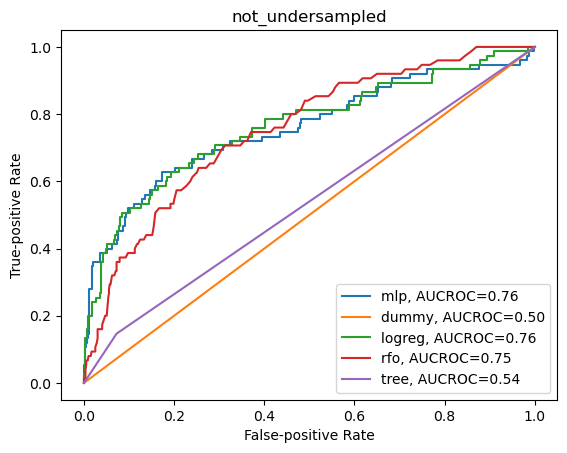

In [182]:
undersample_label= const.US_NO
y_probas={
    #const.METHOD_CNN: predictions_cnn_fast[const.PROBABILITIES],
    const.METHOD_MLP: predictions_mlp[const.PROBABILITIES],
    const.METHOD_DUMMY: baseline_models[undersample_label][const.METHOD_DUMMY].predicted_probas[:,1],
    const.METHOD_LR: baseline_models[undersample_label][const.METHOD_LR].predicted_probas[:,1],
    const.METHOD_RFO: baseline_models[undersample_label][const.METHOD_RFO].predicted_probas[:,1],
    const.METHOD_TREE: baseline_models[undersample_label][const.METHOD_TREE].predicted_probas[:,1]
}
Utility.plot_auc_roc(y_test,y_probas,undersample_label,bacterial_species,predicted_antibiotic)    

## AUPRC

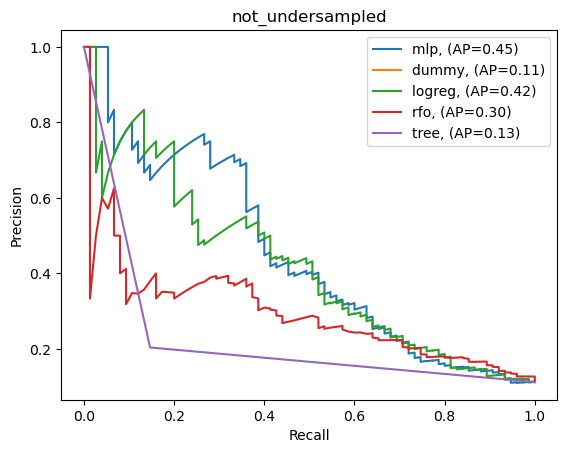

In [183]:
undersample_label= const.US_NO
y_probas={
    #const.METHOD_CNN: predictions_cnn_fast[const.PROBABILITIES],
    const.METHOD_MLP: predictions_mlp[const.PROBABILITIES],
    const.METHOD_DUMMY: baseline_models[undersample_label][const.METHOD_DUMMY].predicted_probas[:,1],
    const.METHOD_LR: baseline_models[undersample_label][const.METHOD_LR].predicted_probas[:,1],
    const.METHOD_RFO: baseline_models[undersample_label][const.METHOD_RFO].predicted_probas[:,1],
    const.METHOD_TREE: baseline_models[undersample_label][const.METHOD_TREE].predicted_probas[:,1]
}
Utility.plot_auc_prc(y_test,y_probas,undersample_label,bacterial_species,predicted_antibiotic)  